Author - Ethan Millar [2022]

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import math
import scipy as sp
import sys
from sys import getsizeof
from numpy.polynomial.chebyshev import Chebyshev as Cheb
from numpy.random import rand
from scipy.signal import tukey
import time
import corner
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

sns.set_context('talk')
sns.set_style('ticks')

import torch.nn.functional as F

from nflows.distributions import StandardNormal
from nflows import transforms
from nflows.nn.nets import ResidualNet
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms as T

import bilby

# Reproducibility

Setting the seed for the random number generators, this allows us to create reproduceable results using this particular seed, rather than it being randomised every time

In [2]:
seed =  1234

np.random.seed(seed)
torch.random.manual_seed(seed)


# Define model

Code below is taken from the nflows documentation 

In [3]:
# Defining the base class to build the neural network from, the neural networks inherets from nn.module (the base class for all neural networks in pytorch)
class ImprovedRealNVP(torch.nn.Module):
    
    #The __init__ function is executed when the class is initiated, It allows us to input properties of the class
    def __init__(self, 
    
                n_dims=None, # Number of inputs for the distribution to learn
                n_transforms=None, # Number of transforms to use
                n_layers_per_transform=None, # Number of layers in the neural network used for each transform
                n_neurons_per_layer=None, # Number of neurons per layer in the neural network
                n_conditional_inputs=None): # Chosing the conditions for which to base the new sampels(?)
        
        # Initialising the base class, nn.module along with the first __init__ for our ImprovedRealNVP Class.
        # Without super().__init__() we only inherent the methods of the base class, we need to use super init to run the init of the base class
        super().__init__() 
        
        # Define function for creating the neural network
        def create_net(in_features, out_features):
                return ResidualNet(
                    in_features,
                    out_features,
                    hidden_features=n_neurons_per_layer,
                    context_features=n_conditional_inputs,
                    num_blocks=n_layers_per_transform,
                    activation=F.leaky_relu,
                    dropout_probability=False,
                    use_batch_norm=True
                    )
        
        def create_linear_transform():
            return transforms.CompositeTransform([
                transforms.RandomPermutation(features=n_dims),
                transforms.LULinear(n_dims, identity_init=True,
                                    using_cache=False)
            ])

        # Make an alternating mask. If the value is one, the parameter is updated
        # if it <0 then it is used as the input to the NN
        mask = torch.ones(n_dims)
        mask[::2] = -1

        transforms_list = []
        for i in range(n_transforms):
            transforms_list.append(create_linear_transform())
            transform = transforms.AffineCouplingTransform(
                mask=mask, transform_net_create_fn=create_net
            )
            transforms_list.append(transforms.BatchNorm(features=n_dims))
            mask *= -1
            transforms_list.append(transform)

        self.transform = transforms.CompositeTransform(transforms_list)
        self.distribution = StandardNormal([n_dims])

    def forward(self, x, context=None):
        """
        Apply the forward transformation and return samples in the latent
        space and log |J|
        """
        return self.transform.forward(x, context=context)

    def inverse(self, z, context=None):
        """
        Apply the inverse transformation and return samples in the
        data space and log |J| (not log probability)
        """
        return self.transform.inverse(z, context=context)

    def log_prob(self, x, context=None):
        """
        Computes the log probability of the inputs samples by applying the
        transform.
        """
        z, logabsdet = self.transform(x, context=context)
        log_prob = self.distribution.log_prob(z)
        return log_prob + logabsdet

    def sample(self, n, context=None):
        """
        Produces N samples in the data space by drawing from the base
        distribution and the applying the inverse transform.
        """
        z = self.distribution.sample(n)
        samples, _ = self.transform.inverse(z, context=context)
        return samples

In [4]:
# Set the parameters for the flow, these are traditionally set to factors of 4 (4, 8, 16, 32, 64, etc)
flow = ImprovedRealNVP(
        n_dims=75, # Cheby Order x Mass Number + Number of masses (this is the dimension of the flattened input array) 
        n_transforms=4, 
        n_layers_per_transform=4, 
        n_neurons_per_layer=64, 
        n_conditional_inputs=256)

flow.to('cuda') #Run the flow using GPU

# Defining the optimiser used for training the flow
#
# Adam is used as a replacement optimiser for gradient descent
optimiser = torch.optim.Adam(flow.parameters(), # Returns the learnable parameters of the flow, 
                             lr=1e-3, # Learning rate
                             weight_decay=1e-6) # Adding an l2 regularization term to the loss

# Configure training parameters
n_epochs = 500 # Number of times the dataset is ran through the training algorithm
patience = 50 # The number of epochs after the loss no stops decreasing
batch_size = 500 # The number of samples used per epoch to train the dataset

# Dynamics

Note, the aim of this section was to apply the previous methods to stretch the problem to 4D, but as is apparent in thw following equations, any vector holding information in the z direction is cancelled out, so there's no information stored in the z dimension. This is the case where we are taking the strain being propogated in the z direction. So this section is being correct to adapt to the 2D case

## Reduced Quadrupole Moment

Switching to 2D we have the following expressing for the reduced quadrupole moment (as components of the trace-free quadrupole tensor):

$$Q_{ij} = \int \rho(\bar x)(3 x_i x_j - |\bar x|^2 \delta_{ij})d \bar x$$ 

where $\bar x $ is the position vector of 3 dimensions, $x_i$, $x_j$, $x_k$ or simply $x$, $y$, $z$.

However we are considering point masses, which has infinite density at the location of the mass and 0 anywhere else, hence:

$$\rho(\bar x) \propto \sum_{k = 1}^{N} m_k \delta(\bar x - \bar x_{k}^{'})$$

It is described by a delta function as it 0 anywhere where $\bar x$ is not equal to the position vector of the point mass, $k$ in question. So we have the following expression for the reduced quadrupole tensor:#

$$Q_{ij} \propto \sum_{k = 1}^{N} m_k(3 x_{i,k}^{'} 3x_{j,k}^{'} - |\bar x|^2 \delta_{ij})d \bar x$$ Where $i$ and $j$ are representing dimensions and $k$ is representing the full position vector of mass $k$

As with the 1D case, we must also window the dynamics to simulate the burst motion of the masses, which gives the following expression:

$$Q_{ij} \propto \sum_{k = 1}^{N} m_k(3 X_{i,k} 3x_{j,k} - |\bar X|^2 \delta_{ij})d \bar x$$ Where $\bar X = [x(t), y(t), z(t)]_k \times w(t)$

For training we will be using the component $h_{xx}$ of the strain tensor (we will also be storing values for $h_{yy}$ and $h_{xy}$ for use of the antenna response function as a future 
adaptation, but for now we will only be using $h_{xx}$)

We use the following expression: $h_{xx} = \frac{d^2 (Q_{xx} - Q_{yy})}{dt^2}$ Which is obtained as follows:

$$Q_{xx} - Q_{yy} \propto \sum_{k = 1}^{N} m_k(3 X_{x,k} - 3X_{y,k})$$

The second derivative solution can be found in the documents folder

## Window Function

As previously, the window function is defined as follows:

$$ w(x)=   \left\{
\begin{array}{ll}
      \frac{1}{2} (1 + cos\left(\frac{2 \pi}{\alpha} [x - \frac{\alpha}{2}]\right) & 0 \leq x \leq \frac{\alpha}{2} \\
      1 & \frac{\alpha}{2} \leq x \leq 1 - \frac{\alpha}{2} \\
      \frac{1}{2} (1 + cos\left(\frac{2 \pi}{\alpha} [x - \frac{\alpha}{2}]\right) & 1 - \frac{\alpha}{2} \leq x \leq 1 \\
\end{array} 
\right.  $$

$$ w'(x)=   \left\{
\begin{array}{ll}
      - \frac{1}{a}\pi sin(\frac{2 \pi x}{a} - \pi) & 0 \leq x \leq \frac{\alpha}{2} \\
      0 & \frac{\alpha}{2} \leq x \leq 1 - \frac{\alpha}{2} \\
      - \frac{1}{a}\pi sin(\frac{2 \pi x}{a} - \pi) & 1 - \frac{\alpha}{2} \leq x \leq 1 \\
\end{array} 
\right.  $$

$$ w''(x)=   \left\{
\begin{array}{ll}
      - \frac{1}{a^2}2 \pi^2 cos(\frac{2 \pi x}{a} - \pi) & 0 \leq x \leq \frac{\alpha}{2} \\
      0 & \frac{\alpha}{2} \leq x \leq 1 - \frac{\alpha}{2} \\
      - \frac{1}{a^2}2 \pi^2 cos(\frac{2 \pi x}{a} - \pi) & 1 - \frac{\alpha}{2} \leq x \leq 1 \\
\end{array} 
\right.  $$

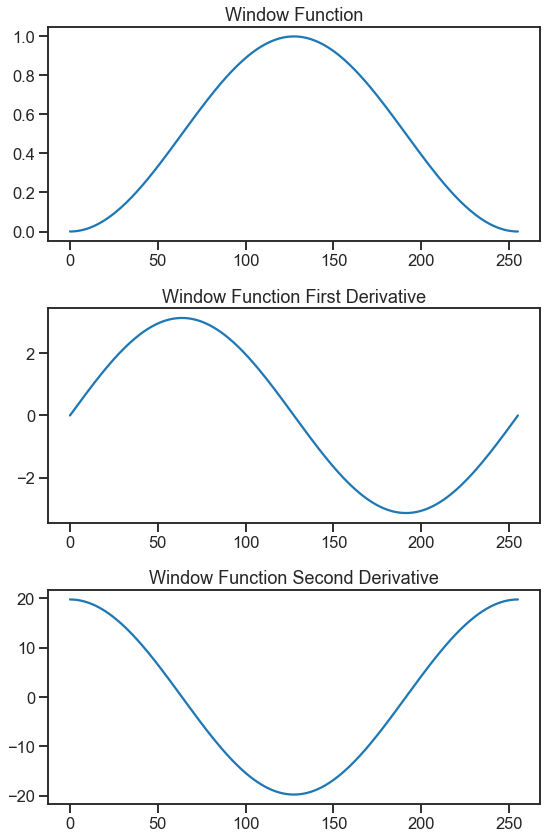

In [5]:
# Defining a function to compute the Tukey function and its derivatives as above

def tukey_win(sample_points, alpha = 1): 
    
    # After testing we chose a value of 1 for alpha to create a smooth, continuous window function to prevent artifacts in the mass dynamics
    # It was found when using an alpha value less than that then the second derivative of the window function caused issues due to this reason
    # Ideally, an alternative window function would have been created to have the flat line at y = 1 but with a fully smooth and continuous function
    # But for now we stuck with the tukey function with an alpha value of 1, while this tapers very gradually, it at leasts allows us to get a burst
    # dynamic motion
    
    y = np.zeros(sample_points) #Generating a zeros array and adding 1 to account for the 0 (so 257 total numbers)
    
    # Using a loop to iterate over a linear array of len of sample rate in order to generate the piecewise function
    
    for i, point in enumerate(np.linspace(0, sample_points, sample_points)): # enumerate does "for {index}, {value}"
        if point <= alpha/2 * sample_points:
            y_new = 0.5 * (1 + np.cos(((2 * np.pi) / alpha) * (point - (alpha / 2)))) 

        elif alpha/2 * 256 <= point <= (1 - (alpha/2)) * 256:
             1

        elif point >= (1 - (alpha/2)) * 256:
            y_new = 0.5 * (1 + np.cos(((2 * np.pi) / alpha) * (point - (alpha / 2)))) 

        y[i] = y_new
        
    
    y_der1 = np.zeros(sample_points)

    for i, point in enumerate(np.linspace(0, sample_points, sample_points)):
        if point <= alpha/2 * sample_points:
            y_new = -(1 / alpha) * np.pi * np.sin(((2 * np.pi * point) / alpha) - np.pi)

        elif alpha/2 * 256 < point < (1 - (alpha/2)) * 256:
             y_new = 0

        elif point > (1 - (alpha/2)) * 256:
            y_new = -(1 / alpha) * np.pi * np.sin(((2 * np.pi * point) / alpha) - np.pi)

        y_der1[i] = y_new
        
    y_der2 = np.zeros(sample_points)

    for i, point in enumerate(np.linspace(0, sample_points, sample_points)):
        if point <= alpha/2 * sample_points:
            y_new = -(1 / alpha**2) * 2 * np.pi**2 * np.cos(((2 * np.pi * point) / alpha) - np.pi)

        elif alpha/2 * 256 < point < (1 - (alpha/2)) * 256:
             y_new = 0

        elif point > (1 - (alpha/2)) * 256:
            y_new = -(1 / alpha**2) * 2 * np.pi**2 * np.cos(((2 * np.pi * point) / alpha) - np.pi)

        y_der2[i] = y_new
        
    return y, y_der1, y_der2 # Returns the orginal window as well as its first and second derivatives

y, y1, y2 = tukey_win(256)


fig = plt.figure(figsize = [8,12])

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.title.set_text('Window Function')
ax2.title.set_text('Window Function First Derivative')
ax3.title.set_text('Window Function Second Derivative')

ax1.plot(y)
ax2.plot(y1)
ax3.plot(y2)

fig.subplots_adjust()
fig.tight_layout()

plt.show()

In [6]:
# Defining the function to generate the chebyshev polynomial series
def dynamics_generation(PolyOrder, sampling):
  # Generating 0 matrices of the chosen chebychev polynomial order for each dimension
    x_coefs = np.zeros(PolyOrder)
    y_coefs = np.zeros(PolyOrder)
    z_coefs = np.zeros(PolyOrder)

    time = np.arange(-1,1,(2/sampling)) # Time interval centered around 0, with a size equal to the sample rate

    for i in range(0,PolyOrder):
    # Generating coefficients from a uniform distribution in range [-1,1]
        x_coefs[i] = (2*rand())-1 
        y_coefs[i] = (2*rand())-1 
        z_coefs[i] = (2*rand())-1 
        #rand() returns a value in the range of 0 to 1, so to get a range of -1 to 1 we multiply by 2 and subtract by 1
    return x_coefs, y_coefs, z_coefs, time # Returns the x coefficients as well as the time across the waveform

As mentioned before, the mathematical expression for the strain can be found in the documents folder. We create a function to compute the chebyshev series for the strain excluding the mass term as that is multiplied later. This strain data will be our labels to tell the flow what strain our simulated mass dynamics produce

In [7]:
# Apply a window function so that our generated strain tapers to zero at t = 0, t = 1
w, w_der1, w_der2 = tukey_win(256) # Using the tukey window function with 256 points, matching our sampling rate, and returning 1st and 2nd derivatives

# Defining a function to perform the chebyshev operations as disucssed
# This function does not include multiplication of the mass, this happens before this function is ran

# By the nature of chebyshev series, we use a seperate function for each operation, and hence we have created a variable for each term in the expression

def strain_xx(time, x_coefs, y_coefs, window): 
    
    
 
    x_squared = np.polynomial.chebyshev.chebpow(x_coefs, 2)
    x_der = np.polynomial.chebyshev.chebder(x_coefs, 1)
    x_squared_der = np.polynomial.chebyshev.chebder(x_der, 1)
    x_der2 = np.polynomial.chebyshev.chebder(x_coefs, 2)
    
    y_squared = np.polynomial.chebyshev.chebpow(x_coefs, 2)
    y_der = np.polynomial.chebyshev.chebder(x_coefs, 1)
    y_squared_der = np.polynomial.chebyshev.chebder(x_der, 1)
    y_der2 = np.polynomial.chebyshev.chebder(x_coefs, 2)

    mul_x_x_der = np.polynomial.chebyshev.chebmul(x_coefs, x_der)
    mul_x_x_der2 = np.polynomial.chebyshev.chebmul(x_coefs, x_der2)
    
    mul_y_y_der = np.polynomial.chebyshev.chebmul(y_coefs, y_der)
    mul_y_y_der2 = np.polynomial.chebyshev.chebmul(y_coefs, y_der2)
    
    
    w, w_der1, w_der2 = tukey_win(256) 
    
    term_1 = np.polynomial.chebyshev.chebval(time, x_squared_der) * w**2
    term_2 = np.polynomial.chebyshev.chebval(time, mul_x_x_der2) * w**2
    term_3 = np.polynomial.chebyshev.chebval(time, mul_x_x_der) * (2 * w) * w_der1
    
    term_4 = np.polynomial.chebyshev.chebval(time, mul_x_x_der) * 2 * w * w_der1
    term_5 = np.polynomial.chebyshev.chebval(time, x_squared) * w * w_der2
    term_6 = np.polynomial.chebyshev.chebval(time, x_squared) * w * w_der1**2
    
    term_7 = np.polynomial.chebyshev.chebval(time, y_squared_der) * w**2
    term_8 = np.polynomial.chebyshev.chebval(time, mul_y_y_der2) * w**2
    term_9 = np.polynomial.chebyshev.chebval(time, mul_y_y_der) * (2 * w) * w_der1
    
    term_10 = np.polynomial.chebyshev.chebval(time, mul_y_y_der) * 2 * w * w_der1
    term_11 = np.polynomial.chebyshev.chebval(time, y_squared) * w * w_der2
    term_12 = np.polynomial.chebyshev.chebval(time, y_squared) * w * w_der1**2
    
    total_dynamics_series = term_1 + term_2 + term_3 + term_4 + term_5 + term_6 + term_7 + term_8 + term_9 + term_10 + term_11 + term_12 
  
    return total_dynamics_series

In [8]:
# Defining a function to generate the values for our masses

def mass_generation(nummass):
  #Generating masses from a uniform distribution 
    masses = np.zeros(nummass)
    for n in range(0, nummass):
        masses[n] = np.random.rand()

    masses = masses/np.sum(masses) # Applying scaling so the total mass = 1, keeping it constant throughout 

    return masses

In [9]:
#Defining the function to generate the data
def data_generation(ChebOrder, nummass, numsamples, window,  samplerate = 256):
# ChebOrder - Order N of Chebyshev Polynomials T_N comprising series
# nummass - Number of masses
# numsamples - Number of Training Samples
# samplerate - Sampling rate (default 256 samples)

    all_masses = np.zeros((numsamples, nummass)) # Array holding the masses along the columns with each row being a sample
    
    # We Generate a flattened Array holding the masses and chebyshev order in the columns, this way when we reshape the array,
    # for a given sample we will have a number of masses x chebyshev order array from which we can generate the mass dynamics from 
    flattened_dynamics_x = np.zeros((numsamples, (nummass*ChebOrder)))
    flattened_dynamics_y = np.zeros((numsamples, (nummass*ChebOrder)))
    flattened_dynamics_z = np.zeros((numsamples, (nummass*ChebOrder)))
    
    # Generating timeseries array with each sample on a column and each row holding the number of points in that sample
    h_xx = np.zeros((numsamples, samplerate)) 
    
    # Creating seperate arrays of the strain timeseries that will not have the window function or any scaling applied 

    h_xx_unscaled = np.zeros((numsamples, samplerate))
    
    # Generating a time array to compute the chebyshev series
    
    time = np.arange(-1,1,(2/samplerate))

    for sample in range(0, numsamples): # Iterating over each sample

        overall_dynamics_x = np.zeros(ChebOrder) # 0 matrix of shape of the chebyshev order, which stores the chebyshev series info
        overall_dynamics_y = np.zeros(ChebOrder)
        overall_dynamics_z = np.zeros(ChebOrder)
        
        mass_values = mass_generation(nummass) # Generating mass values with the specified mass number
        all_masses[sample, :] = mass_values # Filling the mass values for each sample

        for mass in range(0, nummass): # Iterating over each mass

            x, y, z, sampling_points = dynamics_generation(ChebOrder, samplerate) # Returning the chebyshev coefficients as well as sampling points
            flattened_dynamics_x[sample, (len(x)*mass):(len(x)*(mass + 1))] = x # Inserting the coefficients into the flattened dynamics array
            flattened_dynamics_y[sample, (len(y)*mass):(len(y)*(mass + 1))] = y
            flattened_dynamics_z[sample, (len(z)*mass):(len(z)*(mass + 1))] = z
            
            overall_dynamics_x = np.add(overall_dynamics_x,(mass_values[mass]*np.array(x))) # Ammending the dynamics array wih the chebyshev coefficients * mass as per eq
            overall_dynamics_y = np.add(overall_dynamics_y,(mass_values[mass]*np.array(y)))
            overall_dynamics_z = np.add(overall_dynamics_z,(mass_values[mass]*np.array(z)))

        h_xx_unscaled[sample, :] = strain_xx(time, overall_dynamics_x, overall_dynamics_y, window) # Ammending strain array with the chebyshev timeseries for each sample
   
    h_xx = h_xx_unscaled/np.abs(np.max(h_xx_unscaled)) # Applying normalisation
    h_yy = -h_xx

  
    flat_dynamics_xyz = np.concatenate((flattened_dynamics_x, flattened_dynamics_y, flattened_dynamics_z ), axis=1) # Storing the mass dynamics for each mass in a flattened array
    flat_samples_xyz = np.concatenate((flat_dynamics_xyz, all_masses), axis=1)
    
    
    #flat_samples_xyz = np.zeros((numsamples, 81)) #81 is the length of x, y, and z samples, temporary solution to make it run, swap this with a more general way
    
    #for sample in range(0, numsamples):
        
        #flat_samples_xyz[sample,:] = np.concatenate((flat_samples_x[sample, :], flat_samples_y[sample, :],  flat_samples_z[sample, :]))

    return all_masses, sampling_points, flat_samples_xyz, h_xx, h_yy

In [10]:
start_time = time.time() # To be used to inform the time taken to generate the data
totalSamples = 100000 # Select how many samples the generate, for each sample we generate 2D mass dynamics with a corresponding strain
massnum = 3 # Seleting the number of masses to simulate
Order = 8 # Chosing the order of chebyshev series, the higher the order, the higher frequencies avaliable 
window = tukey_win(256) # Defining window function with a chosen sample rate

curveweights, sample_len, flat_samples_xyz, h_xx, h_yy = data_generation(Order, massnum, totalSamples, window)

elapsed_time = time.time() - start_time

print(elapsed_time)

301.6081290245056


In [11]:
sample_dim = 24 # The dimensions of each sample array, (8 x 3), to allow us to take chunks out of the total mass dynamics and return the singular x,y components

## Visualising the Data

Below is an example of how the data is stored and retrieved by shaping arrays, here we retrieve the x component of motion for the first sample, as well as the corresponding strain

In [12]:
t = np.arange(-1,1,(2/256))

print(np.shape(flat_samples_xyz))

sample_1_dynamics = flat_samples_xyz[0,0:len(flat_samples_xyz[0,:]) - massnum]

np.shape(sample_1_dynamics)

sample_1_x = sample_1_dynamics[0:sample_dim]

sample_1_y = sample_1_dynamics[sample_dim + 1: sample_dim + 1 + sample_dim]

print(np.shape(sample_1_x))

unflattened_sample_1_x = sample_1_x.reshape((massnum, Order))
unflattened_sample_1_y = sample_1_y.reshape((massnum, Order))

print(np.shape(unflattened_sample_1_x))

source_tseries_x1 = np.polynomial.chebyshev.chebval(t, unflattened_sample_1_x[1, :])
source_tseries_y1 = np.polynomial.chebyshev.chebval(t, unflattened_sample_1_y[1, :])

(100000, 75)
(24,)
(3, 8)


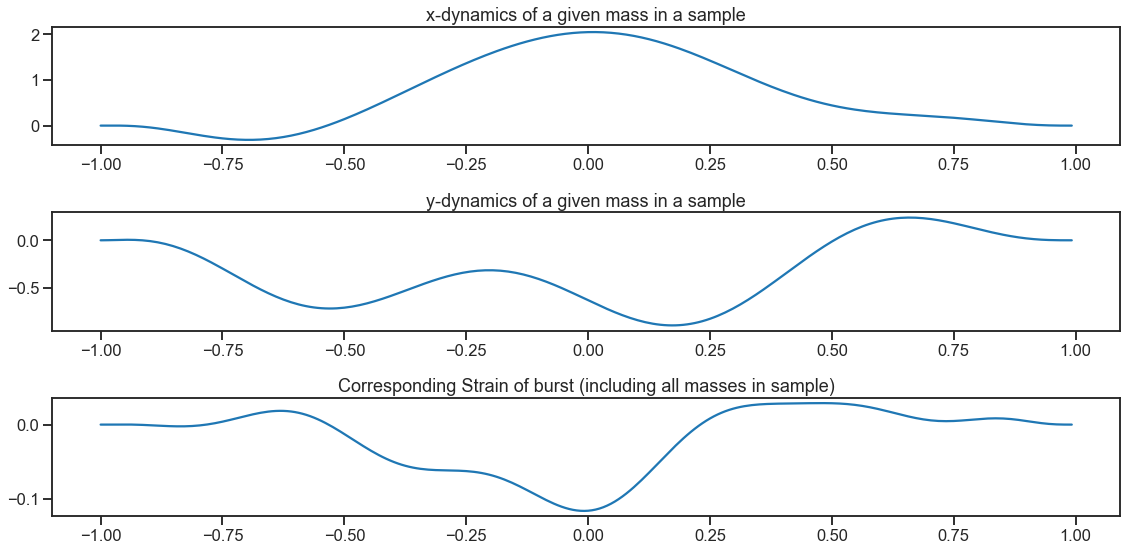

In [40]:
fig = plt.figure(figsize = [16,8])

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.title.set_text('x-dynamics of a given mass in a sample')
ax2.title.set_text('y-dynamics of a given mass in a sample')
ax3.title.set_text('Corresponding Strain of burst (including all masses in sample)')

ax1.plot(t, source_tseries_x1 * w)
ax2.plot(t, source_tseries_y1 * w)
ax3.plot(t, h_xx[0, :])

fig.subplots_adjust()
fig.tight_layout()

plt.show()

# Setting up the Dataset Tensors

In [14]:
samples_tensor = torch.Tensor(flat_samples_xyz)
tensor_strain = torch.Tensor(h_xx)

my_dataset = TensorDataset(samples_tensor, tensor_strain)

train_set, val_set = train_test_split(my_dataset, test_size = 0.1)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Train

In [15]:
%%time
# Variables for checkpointing
best_epoch = 0
best_val_loss = np.inf
best_model = copy.deepcopy(flow.state_dict())

# Loss
loss_dict = dict(train=[], val=[])

for n in range(n_epochs):
    
    # Train
    train_loss = 0
    flow.train()
    for batch_num,(x_tensor, labels) in enumerate(train_loader):
        x_tensor, labels = x_tensor.to('cuda'), labels.to('cuda')
        optimiser.zero_grad()
        loss = -flow.log_prob(x_tensor, context=labels).mean()
        loss.backward()
        optimiser.step()
        train_loss += loss.cpu().detach().numpy()
    train_loss /= len(train_loader)
    loss_dict['train'].append(train_loss)
    
    # Validate
    val_loss = 0
    with torch.no_grad():
        flow.eval()
        for batch_num,(x_tensor, labels) in enumerate(test_loader):
            x_tensor, labels = x_tensor.to('cuda'), labels.to('cuda')
            val_loss += -flow.log_prob(x_tensor, context=labels).mean().cpu().numpy()
    val_loss /= len(test_loader)

    loss_dict['val'].append(val_loss)

    # Save the best model for use at the end
    if val_loss < best_val_loss:
        best_epoch = n
        best_val_loss = val_loss
        best_model = copy.deepcopy(flow.state_dict())
        
    # Print loss every n epochs
    if not n % 5:
        print(f'{n}: Train loss: {train_loss:1.4f}')
        print(f'{n}: Val loss: {val_loss:1.4f}')
        
    # Early stopping
    if n - best_epoch > patience:
        print('Reached patience')
        break

# Load the best model
print('Finished training')
print(f'Best epoch: {best_epoch}')
print(f'Epoch {best_epoch} val loss: {best_val_loss:1.4f}')
print('Loading best model')
flow.load_state_dict(best_model)
flow.eval()

0: Train loss: 58.2510
0: Val loss: 56.1515
5: Train loss: 49.7209
5: Val loss: 49.4806
10: Train loss: 47.0730
10: Val loss: 47.2217
15: Train loss: 45.3125
15: Val loss: 45.1045
20: Train loss: 44.0716
20: Val loss: 44.8956
25: Train loss: 43.0834
25: Val loss: 44.2972
30: Train loss: 42.2436
30: Val loss: 44.2722
35: Train loss: 41.6621
35: Val loss: 42.1372
40: Train loss: 40.9822
40: Val loss: 42.3416
45: Train loss: 40.5583
45: Val loss: 41.7659
50: Train loss: 39.9824
50: Val loss: 40.6516
55: Train loss: 39.6304
55: Val loss: 41.7328
60: Train loss: 39.2095
60: Val loss: 39.7327
65: Train loss: 38.8584
65: Val loss: 39.2732
70: Train loss: 38.4986
70: Val loss: 49.5638
75: Train loss: 38.1037
75: Val loss: 51.6080
80: Train loss: 37.8097
80: Val loss: 40.9268
85: Train loss: 37.6084
85: Val loss: 38.2914
90: Train loss: 37.3472
90: Val loss: 37.8675
95: Train loss: 37.1137
95: Val loss: 38.6838
100: Train loss: 36.8248
100: Val loss: 38.7715
105: Train loss: 36.6708
105: Val lo

ImprovedRealNVP(
  (transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): CompositeTransform(
        (_transforms): ModuleList(
          (0): RandomPermutation()
          (1): LULinear()
        )
      )
      (1): BatchNorm()
      (2): AffineCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=294, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): ResidualBlock(
              (batch_norm_layers): ModuleList(
                (0): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                (1): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              )
              (context_layer): Linear(in_features=256, out_features=64, bias=True)
              (linear_layers): ModuleList(
                (0): Linear(in_features=64, out_features=64, bias=True)
                (1): Linear(in_features=64, out_features=64, bias=Tru

# Loss Plots

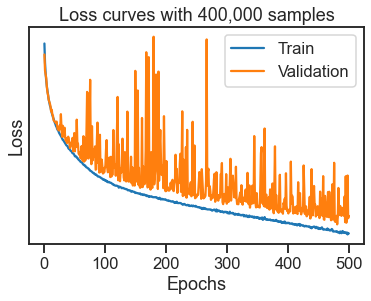

In [16]:
plt.plot(loss_dict['train'], label='Train')
plt.plot(loss_dict['val'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves with 400,000 samples')
plt.yscale('symlog')
plt.show()

# Saving and Loading Model

In [17]:
torch.save(flow.state_dict(), 'model.pt')
torch.save(optimiser.state_dict(), 'optimiser.pt')

In [18]:
flow.load_state_dict(torch.load('model.pt'))
flow.eval()

ImprovedRealNVP(
  (transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): CompositeTransform(
        (_transforms): ModuleList(
          (0): RandomPermutation()
          (1): LULinear()
        )
      )
      (1): BatchNorm()
      (2): AffineCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=294, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): ResidualBlock(
              (batch_norm_layers): ModuleList(
                (0): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                (1): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              )
              (context_layer): Linear(in_features=256, out_features=64, bias=True)
              (linear_layers): ModuleList(
                (0): Linear(in_features=64, out_features=64, bias=True)
                (1): Linear(in_features=64, out_features=64, bias=Tru

# Sample Generation

In [19]:
with torch.no_grad():
    x, c = next(iter(test_loader))

np.shape(c.unsqueeze(0))

torch.Size([1, 500, 256])

In [20]:
# This code essentially is a larger scale version of the "visualising the data" section


with torch.no_grad():
    x = x[0].unsqueeze(0) 
    c = c[0] 
    x_out = flow.sample(1, c.unsqueeze(0).to('cuda')).cpu().numpy()
    source = x.detach().cpu().numpy().squeeze()
    
    source_dynamics = source[0:len(source) - massnum]
    
    source_dynamics_x = source_dynamics[0:sample_dim] # sample_dim = 24 (cheb order x mass number)
    source_dynamics_y = source_dynamics[sample_dim + 1: sample_dim + 1 + sample_dim]
    source_dynamics_z = source_dynamics[len(source_dynamics) - sample_dim: len(source_dynamics)]
    
    source_dyn_unflattened_x = source_dynamics_x.reshape((massnum, Order))
    source_dyn_unflattened_y = source_dynamics_y.reshape((massnum, Order))
    source_dyn_unflattened_z = source_dynamics_z.reshape((massnum, Order))
    
    recon = x_out.squeeze()
    
    recon_dyn = recon[0:len(recon[0,:]) - massnum]
    
    recon_dynamics_x = recon_dynamics[0:sample_dim] 
    recon_dynamics_y = recon_dynamics[sample_dim + 1: sample_dim +1 + sample_dim]
    recon_dynamics_z = recon_dynamics[len(recon_dynamics) - sample_dim: len(recon_dynamics)]
    
    recon_dyn_unflattened_x = recon_dynamics_x.reshape((massnum, Order))
    recon_dyn_unflattened_y = recon_dynamics_y.reshape((massnum, Order))
    recon_dyn_unflattened_z = recon_dynamics_z.reshape((massnum, Order))
    
   
    t = np.arange(-1,1,(2/256))
    t_shifted = np.arange(0,1,(1/256))
    
    c = c.cpu().squeeze()
    
    recon_summed_dyn = np.zeros(Order)
    source_summed_dyn = np.zeros(Order)
    
    recon_masses = recon[(len(recon)-massnum):len(recon)]
    source_masses = source[(len(source)-massnum):len(source)]

    size = (16,6)
    fig, axes = plt.subplots(3, 1, figsize=size)

    for mass in range(0, massnum):
        source_tseries_x = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened_x[mass, :])
        source_tseries_y = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened_y[mass, :])
        source_tseries_z = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened_z[mass, :])
        
        recon_tseries_x = np.polynomial.chebyshev.chebval(t, recon_dyn_unflattened_x[mass, :])
        recon_tseries_y = np.polynomial.chebyshev.chebval(t, recon_dyn_unflattened_y[mass, :])
        recon_tseries_z = np.polynomial.chebyshev.chebval(t, recon_dyn_unflattened_z[mass, :])
        
        axes[0].plot(t_shifted, source_tseries_x, label=mass)
        axes[1].plot(t_shifted, source_tseries_y, label=mass)
        axes[2].plot(t_shifted, source_tseries_z, label=mass)
        
        axes[3].plot(t_shifted, recon_tseries_x, label=mass)
        axes[4].plot(t_shifted, recon_tseries_y, label=mass)
        axes[5].plot(t_shifted, recon_tseries_z, label=mass)
        
        recon_summed_dyn_x += (recon_dyn_unflattened_x[mass, :] * recon_masses[mass])
        recon_summed_dyn_y += (recon_dyn_unflattened_y[mass, :] * recon_masses[mass])
        recon_summed_dyn_z += (recon_dyn_unflattened_z[mass, :] * recon_masses[mass])
    
    
    recon_htseries_unnorm = strain(t_shifted, recon_summed_dyn_x, recon_summed_dyn_x, window)
    recon_htseries = recon_htseries_unnorm / np.abs(np.max(recon_htseries_unnorm))

    axes[0].set_title("Source Dynamics - x, y, z")
    axes[3].set_title("Reconstructed Dynamics - x, , z")
    axes[6].set_title("Strain")
    
    axes[6].plot(t_shifted, recon_htseries)
    axes[6].plot(t_shifted, c, color='r')

    

fig.subplots_adjust()
fig.tight_layout()
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\nflows\transforms\lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
c = c.unsqueeze(0)

In [ ]:
from matplotlib.lines import Line2D
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
source_tseries_array = np.zeros((8,256))
t_shifted = np.arange(0,1,(1/256))

plt.setp(axes, xlim=(0,np.max(t_shifted+0.01)))

with torch.no_grad():
    for j in range (0,50):
        recon_summed_dyn = np.zeros(Order)
        x_out = flow.sample(1, c.to('cuda')).cpu().numpy()
        recon = x_out.squeeze()
        recon_dyn = recon[0:(len(recon)-massnum)]
        recon_unflattened_dyn = recon_dyn.reshape((massnum, Order))
        recon_masses = recon[(len(recon)-massnum):len(recon)]
        recon_masses_rescaled = (0.95*((recon_masses - np.min(recon_masses))/(np.max(recon_masses) - np.min(recon_masses))))+0.05
        source_masses_rescaled = (0.95*((source_masses - np.min(source_masses))/(np.max(source_masses) - np.min(source_masses))))+0.05
        for mass in range(0, 8):
        #Use random latent space point z to produce multiple possible dynamics for a single strain
            recon_tseries = np.polynomial.chebyshev.chebval(t, recon_unflattened_dyn[mass, :])
   
            if mass == 0:
                axes[mass].plot(t_shifted, recon_tseries, color='r', alpha = recon_masses_rescaled[mass])
                axes[mass].set_xlim([0, np.max(t_shifted)])
            recon_summed_dyn += (recon_unflattened_dyn[mass, :] * recon_masses[mass])

        x_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
        x_hcoefs = np.polynomial.chebyshev.chebder(x_coefsq,2)
        recon_htseries = window * np.polynomial.chebyshev.chebval(t, x_hcoefs)
        recon_htseries = recon_htseries / np.abs(np.max(HTseries_unscaled))
        
        axes[1].plot(t_shifted, recon_htseries, 'r')
    axes[1].plot(t_shifted, c.squeeze(), color='k', ls='--', label = 'Noisy Strain')
    h_sample_1 = HTseries[360000,:]
    axes[1].plot(t_shifted, h_sample_1, color='b', ls='-', label = 'Noiseless strain')

    for mass in range(0, 8):
        source_tseries_array[mass,:] = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
        source_tseries = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
    axes[0].plot(t_shifted, source_tseries, 'k--')
      
    fig.subplots_adjust()
    fig.tight_layout()
    axes[0].set_xticks(np.arange(0,1.01,0.1))
    axes[1].set_xticks(np.arange(0,1.01,0.1))
    axes[0].tick_params(axis='both', which='major', labelsize=20)
    axes[1].tick_params(axis='both', which='major', labelsize=20)
    axes[0].grid(b=bool)
    axes[1].grid(b=bool)
    axes[1].set_xlabel('Time (s)', fontsize=20)
    axes[0].set_ylabel('Position', fontsize=20)
    axes[1].set_ylabel('Strain', fontsize=20)
    
    axes[0].set_title("Single Particle Mass Dynamics Reconstruction")
    axes[1].set_title("Strain")
    
    plt.legend()
    fig.tight_layout()
    plt.show()

# Testing Data/Model

## SNR Plots

In [22]:
sigma = 0.05
snr = []
for n in np.arange(0, totalSamples):
    snr_squared = np.sum((h_xx[n,:])**2) / sigma**2
    snr.append(np.sqrt(snr_squared))

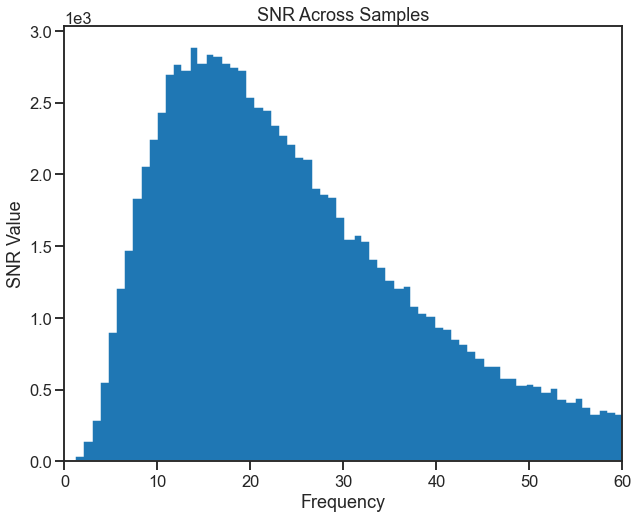

In [23]:
plt.figure(figsize = [10,8])
plt.title('SNR Across Samples')
plt.hist(snr, bins = 250, histtype='stepfilled')
plt.xlabel('Frequency')
plt.ylabel('SNR Value')
plt.xlim(0,60)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()